# Working with Large Point Clouds 
This notebook will explain how use PyForestScan with large data sets. Code snippets for how to get started using PyForestScan or calculate key forest metrics can be found in the notebooks getting-started-importing-preprocessing-dtm-chm or calculate-forest-metrics, and in the documentation. 

For this tutorial, we will use lidar that is hosted by USGS in their 3D Elevation Program (3DEP) (USGS 2025). This data contains over 113 billion points and has a nominal pulse spacing of 0.35 meters covering the Big Island of Hawaii. 

First we will load the necessary python packages and functions.

In [1]:
import geopandas as gpd
import numpy as np

from pyforestscan.handlers import read_lidar, create_geotiff, write_las
from pyforestscan.visualize import plot_metric, plot_2d
from pyforestscan.calculate import assign_voxels, calculate_pad, calculate_pai, calculate_fhd, calculate_chm
from pyforestscan.process import process_with_tiles
from pyforestscan.utils import get_srs_from_ept

## Import Data
PyForestScan leverages PDAL and Entwine to read EPT and COPC data formats. EPT and COPC are optimized for handling very large point clouds and have spatial knowlege of the data, allowing us to access metadata for the entire dataset while working with extracts. We will use this to extract only points that fit within the one kilometer tile that we explored in the other examples. 

In [2]:
bounds = ([-17348441.871880997,-17347398.335829224],[2245235.283966082,2246320.888103429])
ept = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/HI_Hawaii_Island_2017/ept.json"
ept_srs = get_srs_from_ept(ept)
pointclouds = read_lidar(ept, ept_srs, bounds, hag=True)

Once the file is read, we can build the voxels and calculate forest metrics:

In [3]:
voxel_resolution = (5, 5, 1) 
voxels, extent = assign_voxels(pointclouds[0], voxel_resolution)

In [4]:
pad = calculate_pad(voxels, voxel_resolution[-1])
pai = calculate_pai(pad, 1)

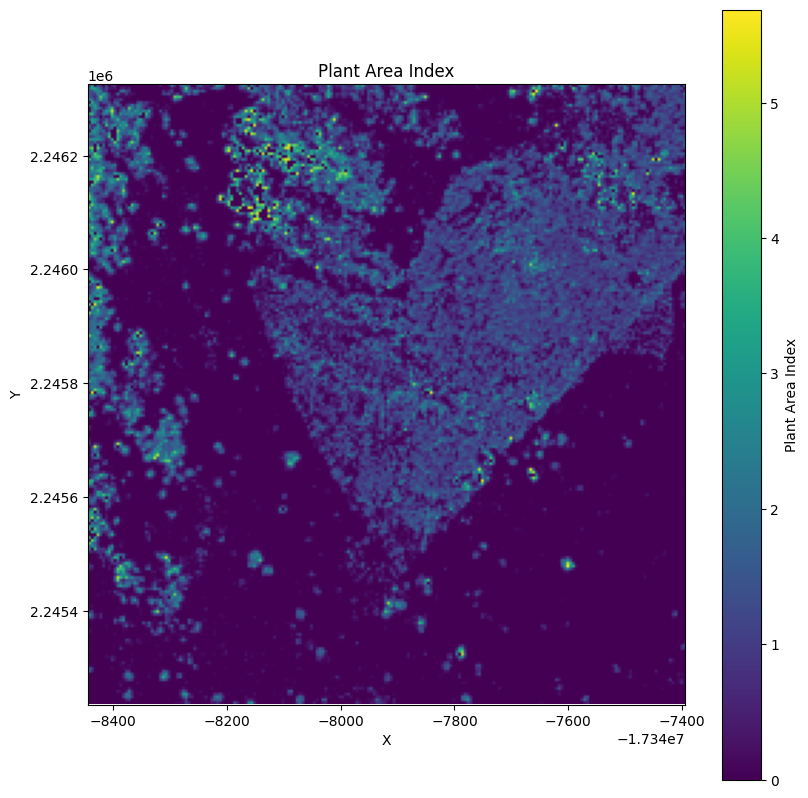

In [5]:
plot_metric("Plant Area Index", pai, extent, metric_name='Plant Area Index', cmap='viridis', fig_size=None)

## Creating Tiled Metrics

We can also generate tiled metrics from the EPT dataset. In this example, we will read from the same EPT file to produce 1000 m × 1000 m tiles of Plant Area Index (PAI) across a larger region, writing each tile as a GeoTIFF. To compute Height Above Ground (HAG) for these tiles, we rely on an existing digital terrain model (DTM).

> Note on HAG with Small Tiles: If you attempt to compute HAG from scratch (e.g., using a Delaunay triangulation) on very small tiles, you may end up with inconsistent ground estimates at tile edges or an insufficient number of ground returns. For best results, either:
> 
> 1.	Use larger tiles so there is enough data in each tile to estimate ground reliably, or
> 
> 2.	Compute HAG once over the entire region (or sufficiently large areas), write the pointcloud with the HeightAboveGround dimension, then tile the data afterward, or
>   
> 3.	Use an existing DTM (as in this example) to derive HAG consistently across tiles.

In [ ]:
bounds = ([-17348441.871880997,-17347398.335829224],[2245235.283966082,2246320.888103429])
ept = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/HI_Hawaii_Island_2017/ept.json"

process_with_tiles(
    ept, 
    (500, 500), 
    "../example_data/tiles", 
    "pai", 
    (5, 5, 1), 
    buffer_size=0.1,
    bounds=bounds,
    hag_dtm=True,
    dtm="../example_data/USGS_1M_4_x83y219_HI_Hawaii_Island_Lidar_NOAA_2017_B17_cropped_3857.tif",
    remove_outliers=True
)

Processing tiles:  78%|███████▊  | 7/9 [01:32<00:21, 10.93s/it]

And we can plot this geotiff using rasterio or load it into a GIS.

In [ ]:
import rasterio
import matplotlib.pyplot as plt

tif_path = "../example_data/tiles/tile_0_0_pai.tif"

with rasterio.open(tif_path) as src:
    raster = src.read(1)
    metadata = src.meta

plt.figure(figsize=(10, 8))
plt.imshow(raster, cmap='viridis')
plt.colorbar(label="Values")
plt.title("Raster Plot")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

## Reading and Clipping to Polygons
We can also read from a large point cloud and only load the points clipped to polygons by making use of the read EPT capabilities and the ability to clip to polygons. This will also allow us to read points that belong to a single and calculate these metrics at the tree level. For example, we can calculate the PAI and FHD for a given tree.

In [ ]:
crowns = gpd.read_file("../example_data/test_segment.gpkg")
crown_geom = crowns.geometry.iloc[0]
minx, miny, maxx, maxy = crown_geom.bounds
bounds = ([minx, maxx], [miny, maxy])
ept_srs = "EPSG:3857"
pointclouds = read_lidar(ept, ept_srs, bounds, crop_poly=True, poly=crown_geom.wkt, hag=True)

Now to plot with points colored by height above ground:

In [ ]:
plot_2d(pointclouds[0], x_dim='X', y_dim='Z', alpha=0.5, point_size=50, fig_size=(10, 10))

And we can calculate metrics for the tree by setting the voxel size to be that of the bounds of the clipped point:

In [ ]:
voxel_resolution = (maxx - minx, maxy - miny, 1) 
voxels, extent = assign_voxels(pointclouds[0], voxel_resolution)
canopy_height, extent = calculate_chm(pointclouds[0], voxel_resolution)
pad = calculate_pad(voxels, voxel_resolution[-1], beer_lambert_constant=0.4)
pai = calculate_pai(pad, 1)
fhd = calculate_fhd(voxels)
# assign_voxels will round the voxel shape to the nearest integer, so padding with 0s is introduced here 
# (since the point cloud was clipped to the crown polygon earlier). We can simply take the max to get values
print("canopy height:", np.nanmax(canopy_height))
print("plant area index:", np.nanmax(pai))
print("foliage height diversity:", np.nanmax(fhd))

# Reference and Acknowledgements

Map services and data available from U.S. Geological Survey, National Geospatial Program. 

USGS (2025). USGS 3DEP LiDAR Point Clouds was accessed on 4/3/2025 from https://registry.opendata.aws/usgs-lidar)